In [66]:
# setup: imports

import scanpy as sc
import anndata as ad

from scripts.utils import setup_validate_paths, harmony_integrate
from scripts.paths import DATA, FIGURES, OUTPUT

# setup: path constants

POSCABLO_PATH = DATA / "rna_annotation_normalized.h5ad"
PNE_PATH = DATA / "pne-bonemarrow.h5ad"
FIGURES_NB = FIGURES / "cluster-age-integrated"
OUTDIR_NB = OUTPUT / "cluster-age-integrated"

# setup: verify paths

setup_validate_paths(
    required_paths=[POSCABLO_PATH, PNE_PATH], output_dirs=[FIGURES_NB, OUTDIR_NB]
)

# can break rendering saved objects in anndata < 0.11
ad.settings.allow_write_nullable_strings = True

In [ ]:
pne = sc.read_h5ad(PNE_PATH)

In [ ]:
# set up objects
poscablo = sc.read_h5ad(POSCABLO_PATH)
pne = sc.read_h5ad(PNE_PATH)

# filter for control HSCs
pne_ctrl = pne[
    (pne.obs["Treatment"] == "CONTROL")
    & (pne.obs["predicted_cell_type"].isin({"HSC"}))
].copy()
del pne

# standardize poscablo metadata to pne conventions
poscablo.obs.drop(
    columns=[
        "nCount_RNA",  # dupe of n_counts
        "nFeature_RNA",  # dupe of n_genes_by_counts
        "pct_counts_mt",  # empty, seurat ver has actual data
    ],
    inplace=True
)
poscablo.obs.rename(
    columns={
        "rna_annotation": "predicted_cell_type",
        "orig.ident": "Sample",
        "percent.mt": "pct_counts_mt",
        "Age": "age_group",
    },
    inplace=True,
)

# set up age columns
pne_ctrl.obs["age_group"] = "Young"

# add dataset
poscablo.obs["dataset"] = "poscablo"
pne_ctrl.obs["dataset"] = "pne"

# keep common genes among datasets
common_genes = poscablo.var_names.intersection(pne_ctrl.var_names)
poscablo = poscablo[:, common_genes].copy()
pne_ctrl = pne_ctrl[:, common_genes].copy()

# split by ages
joint = sc.concat(adatas=[poscablo, pne_ctrl])
young = joint[joint.obs["age_group"] == "Young"].copy()
old = joint[joint.obs["age_group"] == "Old"].copy()
# del poscablo, pne_ctrl

In [68]:
# compute umap coordinates

# total (poscablo + pne HSCs)
sc.pp.pca(joint)
harmony_integrate(joint, key="dataset")
sc.pp.neighbors(joint, use_rep="X_pca_harmony")
sc.tl.umap(joint)

# old (only poscablo cells)
sc.pp.pca(old)
sc.pp.neighbors(old)
sc.tl.umap(old)

# young (poscablo + pne HSCs)
sc.pp.pca(young)
harmony_integrate(young, key="dataset")
sc.pp.neighbors(young, use_rep="X_pca_harmony")
sc.tl.umap(young)

2026-02-20 13:48:25,638 - harmonypy - INFO - Running Harmony (PyTorch on cpu)
2026-02-20 13:48:25,639 - harmonypy - INFO -   Parameters:
2026-02-20 13:48:25,640 - harmonypy - INFO -     max_iter_harmony: 10
2026-02-20 13:48:25,641 - harmonypy - INFO -     max_iter_kmeans: 20
2026-02-20 13:48:25,642 - harmonypy - INFO -     epsilon_cluster: 1e-05
2026-02-20 13:48:25,642 - harmonypy - INFO -     epsilon_harmony: 0.0001
2026-02-20 13:48:25,643 - harmonypy - INFO -     nclust: 100
2026-02-20 13:48:25,643 - harmonypy - INFO -     block_size: 0.05
2026-02-20 13:48:25,645 - harmonypy - INFO -     lamb: [1. 1.]
2026-02-20 13:48:25,646 - harmonypy - INFO -     theta: [2. 2.]
2026-02-20 13:48:25,646 - harmonypy - INFO -     sigma: [0.1 0.1 0.1 0.1 0.1]...
2026-02-20 13:48:25,647 - harmonypy - INFO -     verbose: True
2026-02-20 13:48:25,647 - harmonypy - INFO -     random_state: 0
2026-02-20 13:48:25,648 - harmonypy - INFO -   Data: 50 PCs × 23194 cells
2026-02-20 13:48:25,649 - harmonypy - INFO

In [69]:
# save objects for reference

joint.write_h5ad(filename=OUTDIR_NB/"poscablo_augmented.h5ad")
old.write_h5ad(filename=OUTDIR_NB/"poscablo_augmented_old.h5ad")
young.write_h5ad(filename=OUTDIR_NB/"poscablo_augmented_young.h5ad")

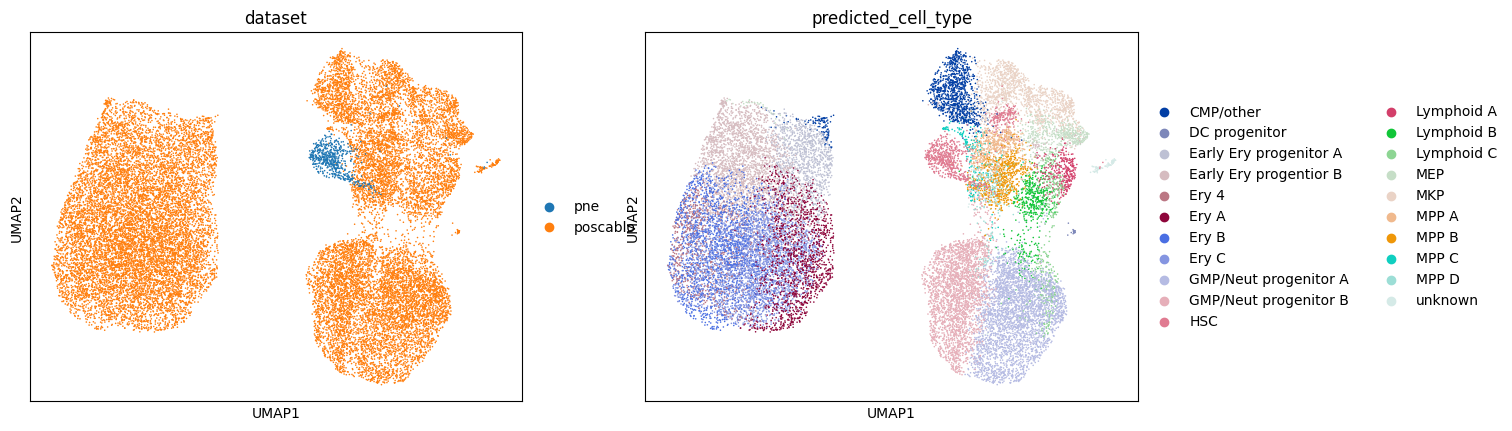

In [ ]:
# all poscablo + pne ctrl hscs (young)... fishy...
sc.pl.umap(joint, color=['dataset', 'predicted_cell_type'])

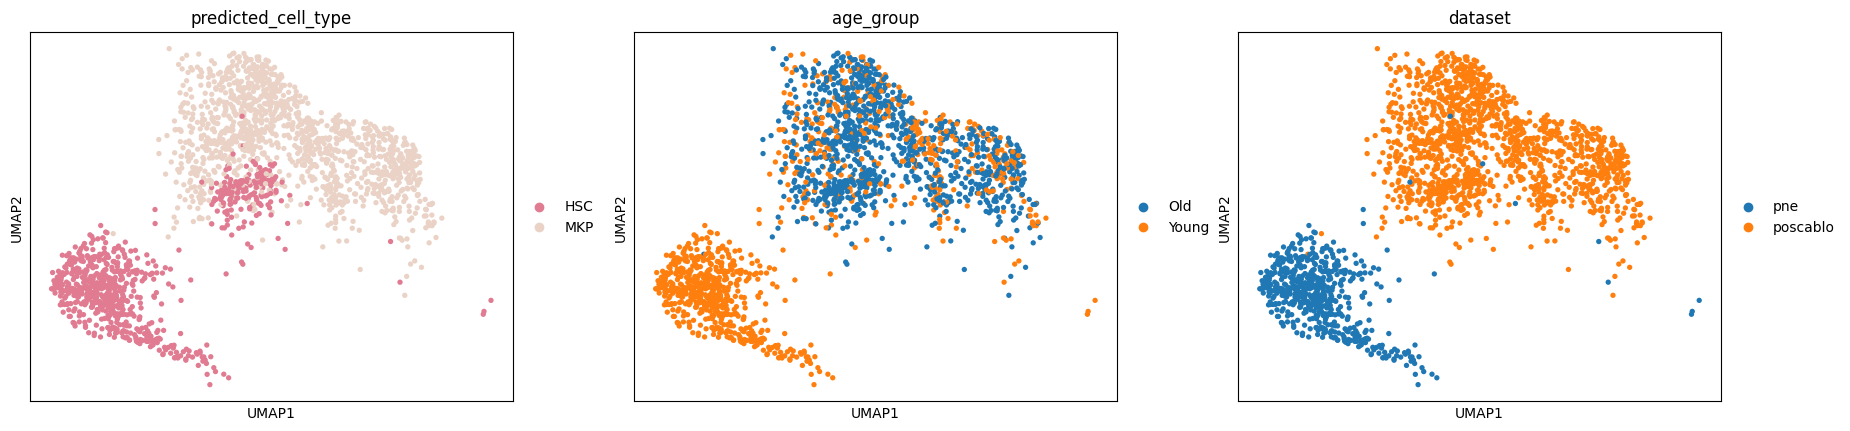

In [ ]:
# subsetting hscs/mkps from joint... still weird...
sc.pl.umap(
    adata=joint[joint.obs['predicted_cell_type'].isin({'HSC', 'MKP'})],
    # adata=joint,
    color=['predicted_cell_type', 'age_group', 'dataset']
)

2026-02-20 14:32:16,746 - harmonypy - INFO - Running Harmony (PyTorch on cpu)
2026-02-20 14:32:16,747 - harmonypy - INFO -   Parameters:
2026-02-20 14:32:16,748 - harmonypy - INFO -     max_iter_harmony: 10
2026-02-20 14:32:16,748 - harmonypy - INFO -     max_iter_kmeans: 20
2026-02-20 14:32:16,749 - harmonypy - INFO -     epsilon_cluster: 1e-05
2026-02-20 14:32:16,749 - harmonypy - INFO -     epsilon_harmony: 0.0001
2026-02-20 14:32:16,750 - harmonypy - INFO -     nclust: 68
2026-02-20 14:32:16,751 - harmonypy - INFO -     block_size: 0.05
2026-02-20 14:32:16,751 - harmonypy - INFO -     lamb: [1. 1.]
2026-02-20 14:32:16,752 - harmonypy - INFO -     theta: [2. 2.]
2026-02-20 14:32:16,753 - harmonypy - INFO -     sigma: [0.1 0.1 0.1 0.1 0.1]...
2026-02-20 14:32:16,753 - harmonypy - INFO -     verbose: True
2026-02-20 14:32:16,754 - harmonypy - INFO -     random_state: 0
2026-02-20 14:32:16,754 - harmonypy - INFO -   Data: 50 PCs × 2047 cells
2026-02-20 14:32:16,755 - harmonypy - INFO -

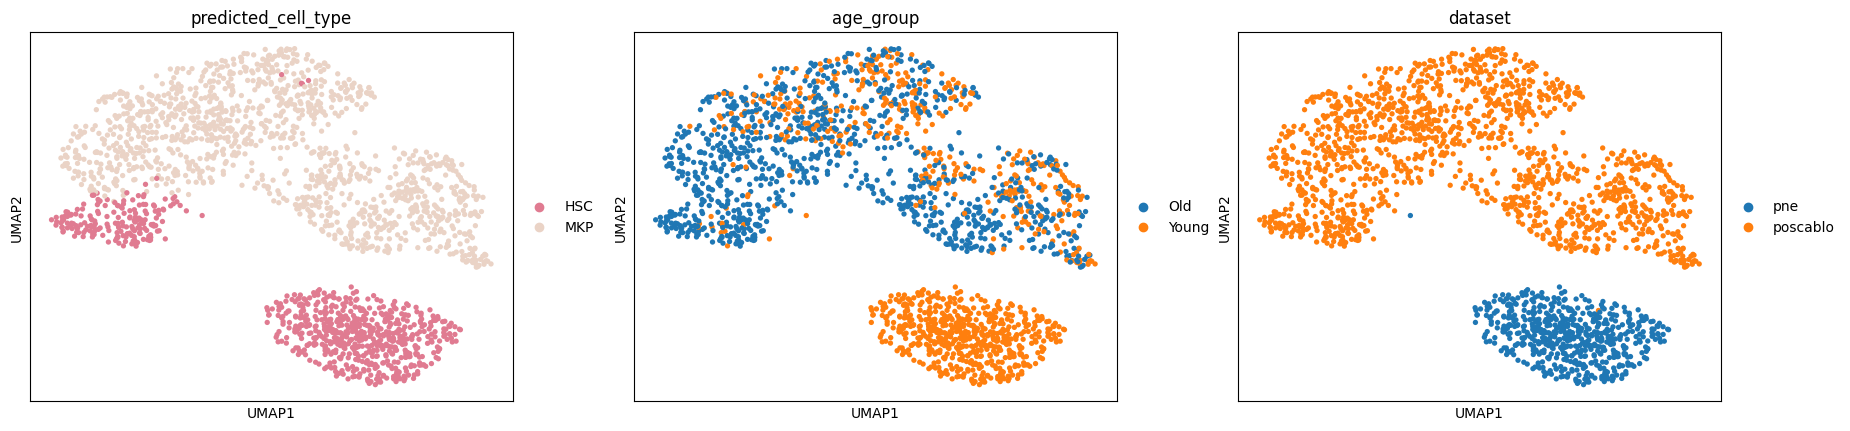

In [ ]:
# whole notebook cell: subset HSC/MKP populations, then recompute all steps (pca, harmony, neighbors, umap)
# VERY WEIRD... maybe a data thing?

hsc_mkp = joint[joint.obs['predicted_cell_type'].isin({'HSC', 'MKP'})].copy()

sc.pp.highly_variable_genes(hsc_mkp, n_top_genes=4000)  # removing makes negligible difference

sc.pp.pca(hsc_mkp)
harmony_integrate(hsc_mkp, key="dataset")  # tried tweaking theta param 2, 4, 10, no diff
sc.pp.neighbors(hsc_mkp)
sc.tl.umap(hsc_mkp)

sc.pl.umap(hsc_mkp, color=['predicted_cell_type', 'age_group', 'dataset'])

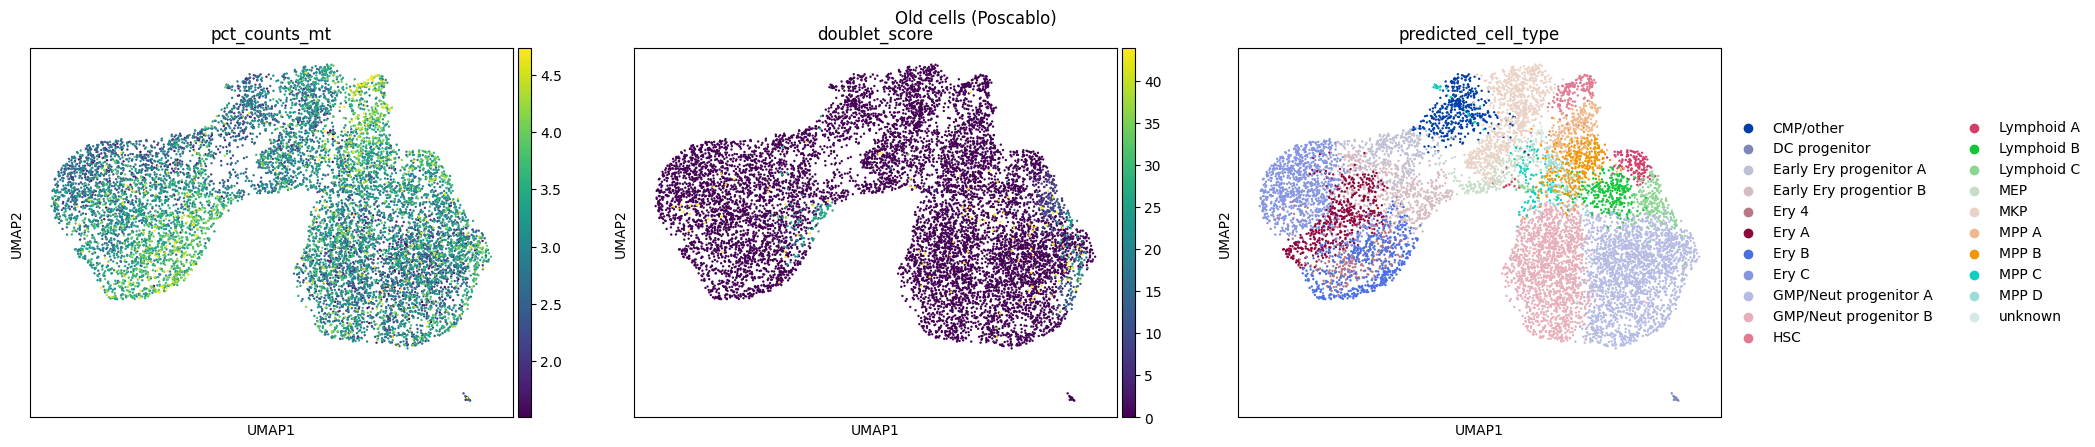

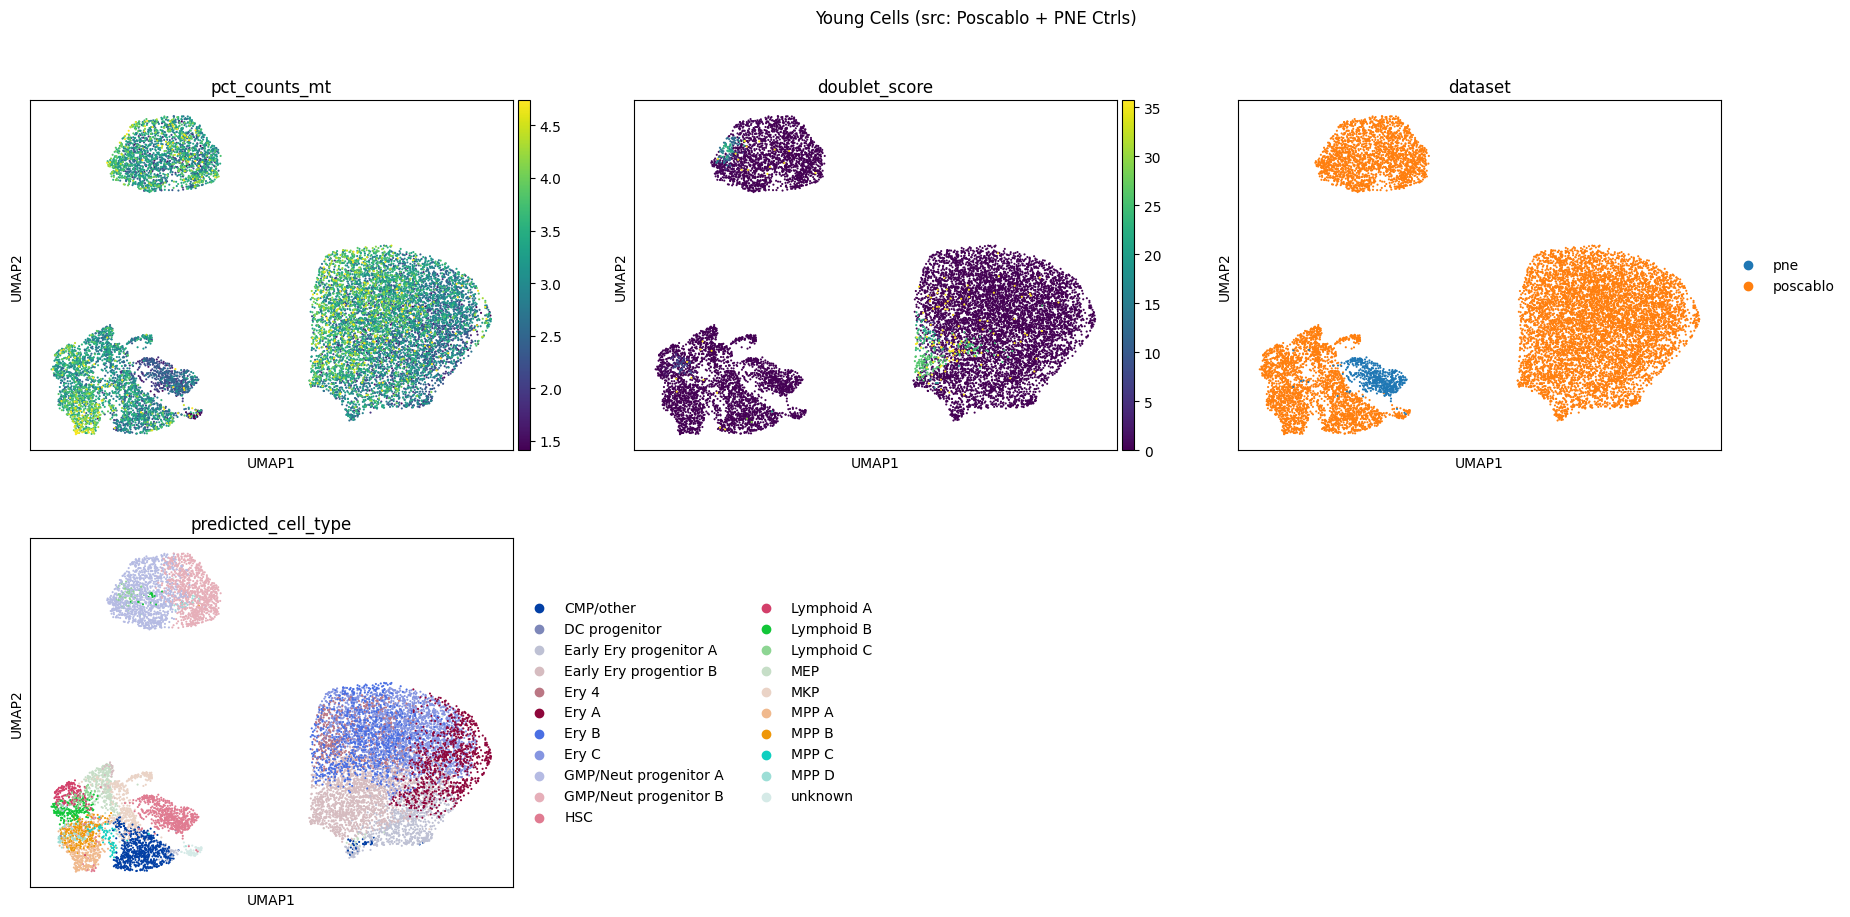

In [98]:
# plot age-specific umaps
oldfig = sc.pl.umap(
    adata=old,
    color=["pct_counts_mt", "doublet_score", "predicted_cell_type"],
    vmax="p99",
    vmin="p1",
    return_fig=True,
    show=False
)

youngfig = sc.pl.umap(
    adata=young,
    color=["pct_counts_mt", "doublet_score", "dataset", "predicted_cell_type"],
    vmin='p1',
    vmax='p99',
    ncols=3,
    return_fig=True,
    show=False
)

oldfig.suptitle("Old cells (Poscablo)")
youngfig.suptitle("Young Cells (src: Poscablo + PNE Ctrls)")
oldfig.show()
youngfig.show()

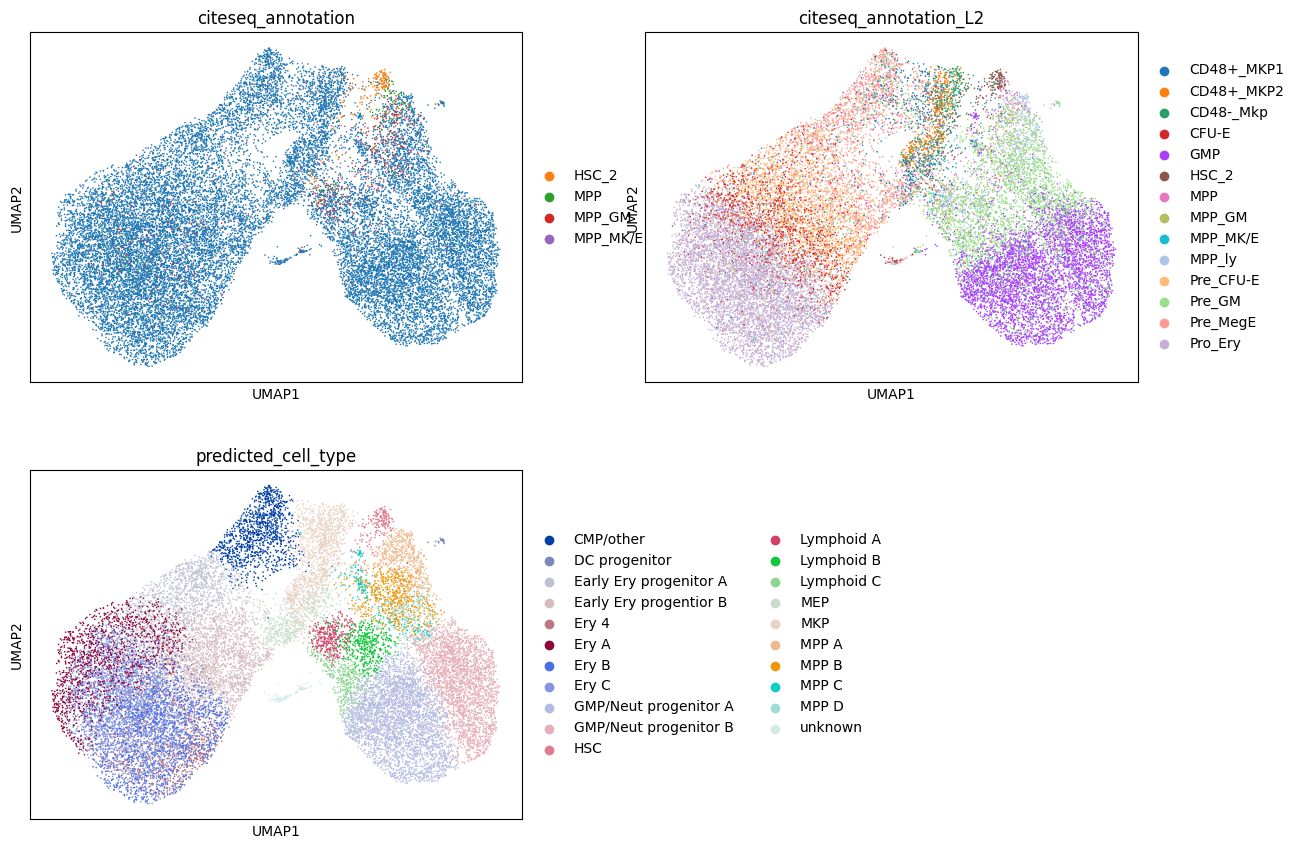

In [ ]:
# just curious
sc.pl.umap(poscablo, color=['citeseq_annotation', 'citeseq_annotation_L2', 'predicted_cell_type'], ncols=2)